<a href="https://colab.research.google.com/github/Freya-LR/strategic_network/blob/master/Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import operator
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, FigureCanvasPdf
from matplotlib.figure import Figure
from matplotlib.collections import LineCollection
from itertools import chain, combinations
import random as rnd
import time
import collections
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
import multiprocessing as mp
from scipy import stats
from scipy.special import expit
from sklearn.linear_model import ARDRegression, LinearRegression,MultiTaskLasso, Lasso
from sklearn.isotonic import IsotonicRegression
from sklearn import preprocessing
from sklearn import utils
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from time import time

from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline

from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import math
import warnings
import matplotlib.cbook
from google.colab import drive
drive.mount('/content/drive')
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Fit Multiple Linear Regression models
def MLR_stable(transitivity, diameter_radius_center_periphery_density, wiener_index,Efficiency_loss,part_rate=-50):  
    '''part_rate: type int ; partition rate of dataset, negtive sign means counting backwards
        transitivity, diameter_radius_center_periphery_density, wiener_index,Efficiency_loss: type: pd.DataFrame
    '''
    print(__doc__)
    
    sta,pv=stats.kstest(Efficiency_loss[0], 'norm')
              
    if pv<0.05:
        print("The Efficiency Loss Data is Normal Distribution !")
    else:
        print("The Efficiency Loss Data is NOT Normal Distribution !")
    D=np.array(diameter_radius_center_periphery_density[4]).reshape((-1,1))
    W=np.array(wiener_index[0]).reshape((-1,1))
    E=np.array(Efficiency_loss[0])
    T=np.array(transitivity[0]).reshape((-1,1))
    W_log=[math.log10(i) for i in W]
    X=[]
    for i in range(len(E)):
        X.append([T[i][0],D[i][0],W[i][0]])

    X_train = X[:part_rate]
    X_test = X[part_rate:]
   
    # Split the targets into training/testing sets
    E_train = E[:part_rate]
    E_test = E[part_rate:]

    """# Create linear regression object
    regr = LinearRegression()

    # Train the model using the training sets
    regr.fit(X, E)

    # Make predictions using the testing set
    E_pred = regr.predict(X_test)
    # The coefficients
    print('Coefficients: \n', regr.coef_)
    # The mean squared error
    print('Mean squared error: %.2f'
          % mean_squared_error(E_test, E_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'
          % regr.score(X, E))
"""
    return X,T,D,W, E


In [ ]:
# Fit CrossValidation and LinearRegression models
def cross_val_stable(X,Efficiency_loss):
    '''transitivity, density, wiener_index,Efficiency_loss: type : np.narray'''
    E=Efficiency_loss 
    # cross_val_predict returns an array of the same size as `y` where each entry
    # is a prediction obtained by cross validation:
    regr = LinearRegression()
    predicted = cross_val_predict(regr, X, E, cv=10)

    fig, ax = plt.subplots()
    ax.scatter(E, predicted, edgecolors=(0, 0, 0))
    ax.plot([E.min(), E.max()], [E.min(), E.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    
    plt.title("Plotting Cross-Validated Predictions")
    plt.tight_layout()
    plt.show()
    return predicted

In [ ]:
# Fit IsotonicRegression and LinearRegression models
def IsotonicReg_stable(x,y):
    '''x: 1D array pd.Series
       y: pd.Series '''
     
    ir = IsotonicRegression()

    y_ = ir.fit_transform(x, y)
    
    
    lr = LinearRegression()
    lr.fit(np.array(x).reshape((-1,1)),y)
    # #############################################################################
    # Plot result

    segments = [[[i, y[i]], [i, y_[i]]] for i in range(len(y))]
    lc = LineCollection(segments, zorder=0)
    lc.set_array(np.ones(len(y)))
    lc.set_linewidths(np.full(len(y), 0.5))

    fig = plt.figure()
    plt.plot(x, y, 'r.', markersize=12)
    plt.plot(x, y_, 'b.-', markersize=12)
    plt.plot(x, lr.predict(np.array(x).reshape((-1,1))), 'y-')
    plt.gca().add_collection(lc)
    plt.xlim(0.5,0.9)
    plt.legend(('Efficiency Loss', 'Isotonic Fit', 'Linear Fit'), loc='lower right')
    plt.title('Isotonic regression')
    plt.xlabel('Density')
    plt.ylabel('Efficiency Loss')
    plt.show()

In [ ]:
def MLPregression(transitivity, diameter_radius_center_periphery_density, wiener_index,Efficiency_loss): 
   
    D=diameter_radius_center_periphery_density[4] #density
    W=wiener_index[0]
    T=transitivity[0]
    y = np.array(Efficiency_loss[0])
    x=[]
    for i in range(len(y)):
        x.append([T[i],D[i],W[i]])


    X=pd.DataFrame(x,columns=['transitivity','density','wiener_index'])
   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=0)
    print("Training MLPRegressor...")
    tic = time()
    est = make_pipeline(QuantileTransformer(),
                        MLPRegressor(hidden_layer_sizes=(50, 50),
                                     learning_rate_init=0.01,
                                     early_stopping=True))
    est.fit(X_train, y_train)
    print("done in {:.3f}s".format(time() - tic))
    print("Test R2 score: {:.2f}".format(est.score(X_test, y_test)))
    print('Computing partial dependence plots...')
    tic = time()
    # We don't compute the 2-way PDP (5, 1) here, because it is a lot slower
    # with the brute method.
    featuresM = ['transitivity', 'density', 'wiener_index',['transitivity', 'density'],['density', 'wiener_index']]
    plot_partial_dependence(est, X_train, featuresM,
                            n_jobs=3, grid_resolution=20)
    print("done in {:.3f}s".format(time() - tic))
    fig = plt.gcf()
    fig.suptitle('Partial dependence of efficiency loss on features\n'
                 'for the Stable Network, with MLPRegressor')
    

    #fig.subplots_adjust(hspace=0.2)
    print("Training GradientBoostingRegressor...")
  
    tic = time()
    esth = HistGradientBoostingRegressor()
    esth.fit(X_train, y_train)
    print("done in {:.3f}s".format(time() - tic))
    print("Test R2 score: {:.2f}".format(esth.score(X_test, y_test)))
    print('Computing partial dependence plots...')
    tic = time()
    featuresG = ['transitivity', 'density', 'wiener_index',
                ['transitivity', 'density'],['density', 'wiener_index'],
               ['transitivity', 'wiener_index']]
    plot_partial_dependence(esth, X_train, featuresG,
                            n_jobs=3, grid_resolution=20)
    print("done in {:.3f}s".format(time() - tic))
    fig = plt.gcf()
    fig.suptitle('Partial dependence of efficiency loss on features\n'
                 'for the Stable Network, with Gradient Boosting')
    #fig.subplots_adjust(wspace=0.4, hspace=0.4)
    # 3D interaction plots
    
    fig = plt.figure()

    features1 = ('transitivity', 'density')
    pdp, axes = partial_dependence(esth, X_train, features=features1,
                                   grid_resolution=20)
    XX, YY = np.meshgrid(axes[0], axes[1])
    Z = pdp[0].T
    ax = Axes3D(fig)
    surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                           cmap=plt.cm.BuPu, edgecolor='k')
    ax.set_xlabel(features1[0])
    ax.set_ylabel(features1[1])
    ax.set_zlabel('Partial dependence')
    #  pretty init view
    ax.view_init(elev=22, azim=122)
    plt.colorbar(surf)
    plt.suptitle('Partial dependence ofefficiency loss on features\n'
                 'for the Stable Network, with Gradient Boosting')
    plt.subplots_adjust(top=0.9)

    plt.show()
    
    fig = plt.figure()

    features2 = ('density', 'wiener_index')
    pdp1, axes1 = partial_dependence(esth, X_train, features=features2,
                                   grid_resolution=20)
    XX, YY = np.meshgrid(axes1[0], axes1[1])
    Z = pdp1[0].T
    ax = Axes3D(fig)
    surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                           cmap=plt.cm.BuPu, edgecolor='k')
    ax.set_xlabel(features2[0])
    ax.set_ylabel(features2[1])
    ax.set_zlabel('Partial dependence')
    #  pretty init view
    ax.view_init(elev=22, azim=122)
    plt.colorbar(surf)
    plt.suptitle('Partial dependence ofefficiency loss on features\n'
                 'for the Stable Network, with Gradient Boosting')
    plt.subplots_adjust(top=0.9)

    plt.show()
    
    plt.show()
    
    fig = plt.figure()

    features3 = ('transitivity', 'wiener_index')
    pdp2, axes2 = partial_dependence(esth, X_train, features=features3,
                                   grid_resolution=20)
    XX, YY = np.meshgrid(axes2[0], axes2[1])
    Z = pdp2[0].T
    ax = Axes3D(fig)
    surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                           cmap=plt.cm.BuPu, edgecolor='k')
    ax.set_xlabel(features3[0])
    ax.set_ylabel(features3[1])
    ax.set_zlabel('Partial dependence')
    #  pretty init view
    ax.view_init(elev=22, azim=122)
    plt.colorbar(surf)
    plt.suptitle('Partial dependence ofefficiency loss on features\n'
                 'for the Stable Network, with Gradient Boosting')
    plt.subplots_adjust(top=0.9)

    plt.show()

In [ ]:
def LDA_SVD(transitivity, diameter_radius_center_periphery_density, wiener_index,Efficiency_loss): 
   
    D=diameter_radius_center_periphery_density[4]
    W=wiener_index[0]
    T=transitivity[0]
    y = np.array(Efficiency_loss[0])
    y_int= y.astype(int)
    x=[]
    for i in range(len(y)):
        x.append([T[i],D[i],W[i]])
    X=pd.DataFrame(x,columns=['transitivity','diameter','wiener_index'])
    y_target = np.unique(y_int)
    colors = ["b","r","sandybrown","olive","c","yellow","navy","plum","purple","brown","pink","g","y","grey","orange","tan"]
    lda = LinearDiscriminantAnalysis(n_components=2)
    X_r2 = lda.fit(X, y_int).transform(X)
    
    plt.figure(figsize=(10,8))
    for color, i, y_target in zip(colors, y_target , y_target):
        plt.scatter(X_r2[y_int == i, 0], X_r2[y_int == i, 1], color=color, alpha=.8, label=y_target)
    plt.legend(loc='best', shadow=False)
    plt.title('LDA of Efficiency Loss')
    plt.show()

    n = 2 # We will take two Singular Values
    U, s, V = np.linalg.svd(X)
    Sig = np.mat(np.eye(n)*s[:n])
    newdata = U[:,:n]
    newdata = pd.DataFrame(newdata)
    newdata.columns=['SVD1','SVD2']
    print(newdata)
    return  y, newdata

transitivity, density, wiener_index,Efficiency_loss: type : np.narray
The Efficiency Loss Data is Normal Distribution !


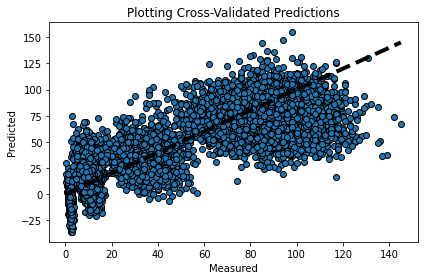

'transitivity, density, wiener_index,Efficiency_loss: type : np.narray'

In [ ]:
with pd.ExcelFile('/content/drive/My Drive/output_values/output_n10_3_combined.xlsx') as reader:
    
    closeness_n10_3_c=pd.read_excel(reader,sheet_name="closeness_centrality")
    betweenness_n10_3_c=pd.read_excel(reader,sheet_name="betweenness_centrality")
    eigenvector_n10_3_c=pd.read_excel(reader,sheet_name="eigenvector_centrality")
    page_rank_n10_3_c=pd.read_excel(reader,sheet_name="page_rank")
    triangles_n10_3_c=pd.read_excel(reader,sheet_name="triangles")
    clustering_n10_3_c=pd.read_excel(reader,sheet_name="clustering")
    wiener_index_n10_3_c=pd.read_excel(reader,sheet_name="wiener_index")
    transitivity_n10_3_c=pd.read_excel(reader,sheet_name="transitivity")
    eccentricity_n10_3_c=pd.read_excel(reader,sheet_name="eccentricity")

    diameter_radius_center_periphery_density_n10_3_c=pd.read_excel(reader,sheet_name="d_r_c_p_d")
    Efficiency_loss_n10_3_c=pd.read_excel(reader,sheet_name="Efficiency_loss")

X_n10_3_c,t_n10_3_c,d_n10_3_c,w_n10_3_c,E_n10_3_c=MLR_stable(transitivity_n10_3_c,
                                      diameter_radius_center_periphery_density_n10_3_c, 
                                      wiener_index_n10_3_c,Efficiency_loss_n10_3_c,part_rate=-300)
node10c_cross_val=cross_val_stable(X_n10_3_c,E_n10_3_c)
#Effiency_LDA_10, SVD_10=LDA_SVD(transitivity_n10_3_c,
                                #diameter_radius_center_periphery_density_n10_3_c,
                               # wiener_index_n10_3_c,Efficiency_loss_n10_3_c)
#regr = LinearRegression()
##regr.fit(SVD_10,Effiency_LDA_10)
#regr.score(SVD_10,Effiency_LDA_10)


'''transitivity, density, wiener_index,Efficiency_loss: type : np.narray'''



Training MLPRegressor...
done in 1.601s
Test R2 score: 0.82
Computing partial dependence plots...
done in 8.371s
Training GradientBoostingRegressor...
done in 0.431s
Test R2 score: 0.83
Computing partial dependence plots...
done in 0.645s


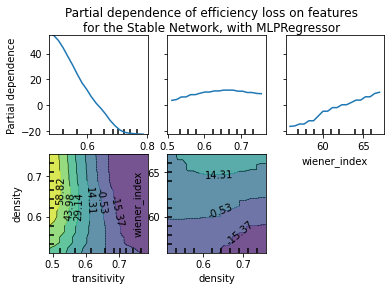

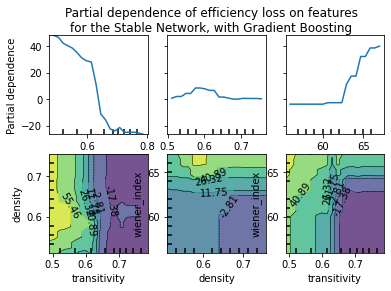

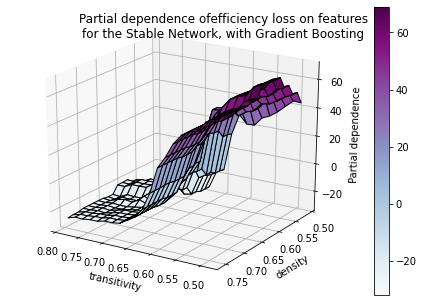

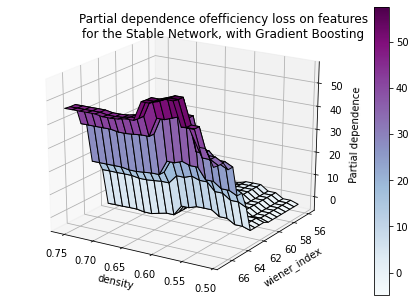

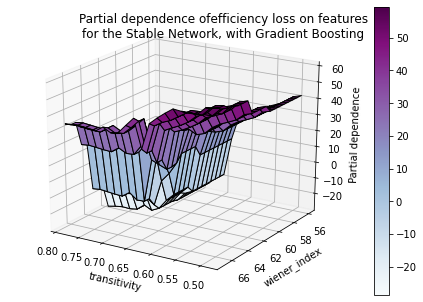

In [ ]:
MLP_n10_3_c=MLPregression(transitivity_n10_3_c, 
                          diameter_radius_center_periphery_density_n10_3_c, 
                          wiener_index_n10_3_c,Efficiency_loss_n10_3_c)
   

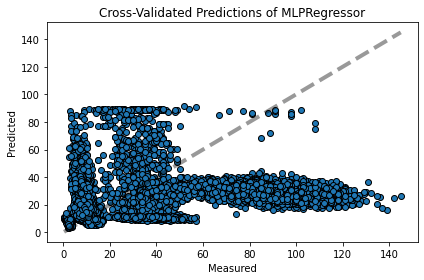

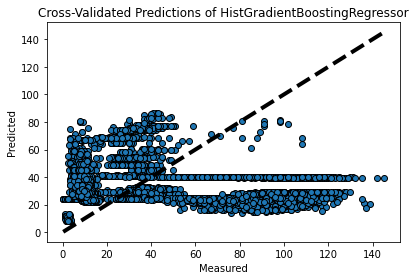

In [ ]:
from sklearn.model_selection import GridSearchCV
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:

mlpr = MLPRegressor(hidden_layer_sizes=(50, 50),
                                     learning_rate_init=0.01,
                                     early_stopping=True)

hgbr=HistGradientBoostingRegressor(loss='least_squares', learning_rate=0.01)

predictedm = cross_val_predict(mlpr, X_n10_3_c, E_n10_3_c , cv=3)
predictedh = cross_val_predict(hgbr, X_n10_3_c, E_n10_3_c , cv=3)

fig1 = plt.figure()
plt.scatter(E_n10_3_c, predictedm, edgecolors=(0, 0, 0))
plt.plot([E_n10_3_c.min(), E_n10_3_c.max()], [E_n10_3_c.min(), E_n10_3_c.max()],
         'k--', lw=4, alpha=0.4)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title("Cross-Validated Predictions of MLPRegressor")
plt.tight_layout()
fig2 = plt.figure()
plt.scatter(E_n10_3_c, predictedh, edgecolors=(0, 0, 0))
plt.plot([E_n10_3_c.min(), E_n10_3_c.max()], [E_n10_3_c.min(), E_n10_3_c.max()], 'k--', lw=4)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title("Cross-Validated Predictions of HistGradientBoostingRegressor")
plt.tight_layout()

plt.show()

In [ ]:
n=10
x=np.zeros((1000,10))
for i in range(n):
    x[:,i]=clustering_n10_3[i]
y = np.array(Efficiency_loss_n10_3[0])  
   
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1,random_state=0)
regr = LinearRegression()

# Train the model using the training sets
regr.fit(x, y)

# Make predictions using the testing set
y_pred = regr.predict(x_test)
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % regr.score(x, y))



Coefficients: 
 [ 9.17406128  5.55062815  4.14746759  3.17511658  2.55016591 -0.77302078
 -2.45382121 -3.55247244 -2.56214907 -0.73752305]
Mean squared error: 3.38
Coefficient of determination: 0.51


transitivity, density, wiener_index,Efficiency_loss: type : np.narray
The Efficiency Loss Data is Normal Distribution !


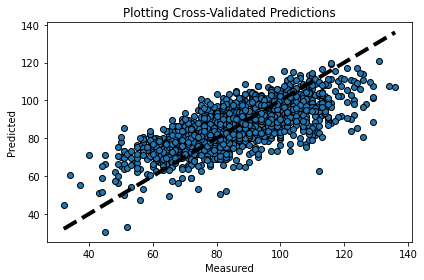

In [ ]:
with pd.ExcelFile('/content/drive/My Drive/output_values/output_n10_3_i_4.xlsx') as reader:
    
    closeness_n10_3_i_4=pd.read_excel(reader,sheet_name="closeness_centrality")
    betweenness_n10_3_i_4=pd.read_excel(reader,sheet_name="betweenness_centrality")
    eigenvector_n10_3_i_4=pd.read_excel(reader,sheet_name="eigenvector_centrality")
    page_rank_n10_3_i_4=pd.read_excel(reader,sheet_name="page_rank")
    triangles_n10_3_i_4=pd.read_excel(reader,sheet_name="triangles")
    clustering_n10_3_i_4=pd.read_excel(reader,sheet_name="clustering")
    wiener_index_n10_3_i_4=pd.read_excel(reader,sheet_name="wiener_index")
    transitivity_n10_3_i_4=pd.read_excel(reader,sheet_name="transitivity")
    eccentricity_n10_3_i_4=pd.read_excel(reader,sheet_name="eccentricity")

    diameter_radius_center_periphery_density_n10_3_i_4=pd.read_excel(reader,sheet_name="d_r_c_p_d")
    Efficiency_loss_n10_3_i_4=pd.read_excel(reader,sheet_name="Efficiency_loss")

X_n10_3_i_4,t_n10_3_i_4,d_n10_3_i_4,w_n10_3_i_4,E_n10_3_i_4=MLR_stable(transitivity_n10_3_i_4,
                                      diameter_radius_center_periphery_density_n10_3_i_4, 
                                      wiener_index_n10_3_i_4,Efficiency_loss_n10_3_i_4,part_rate=-300)
node10_i_4_cross_val=cross_val_stable(X_n10_3_i_4,E_n10_3_i_4)

Training MLPRegressor...
done in 0.450s
Test R2 score: 0.36
Computing partial dependence plots...
done in 3.201s
Training GradientBoostingRegressor...
done in 0.425s
Test R2 score: 0.37
Computing partial dependence plots...
done in 0.365s


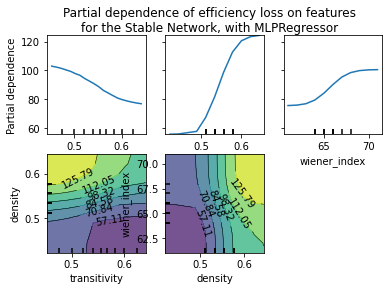

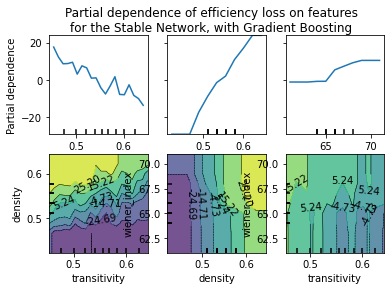

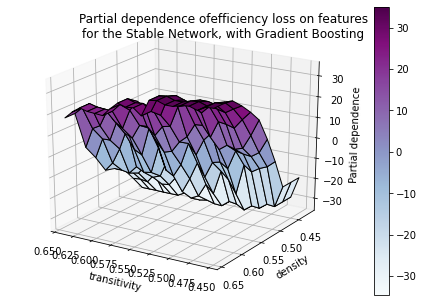

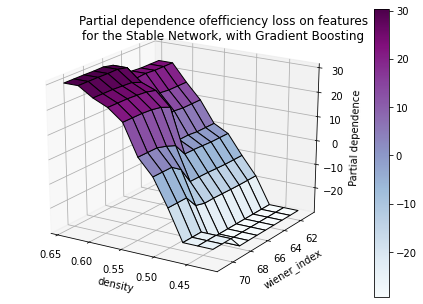

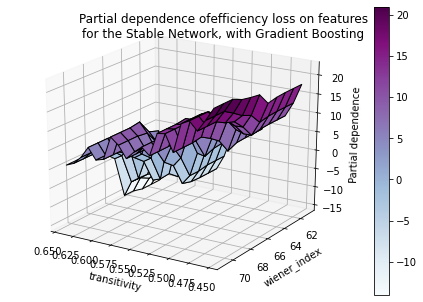

In [ ]:
MLP_n10_3_i_4=MLPregression(transitivity_n10_3_i_4, 
                            diameter_radius_center_periphery_density_n10_3_i_4,
                            wiener_index_n10_3_i_4,Efficiency_loss_n10_3_i_4)
   

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


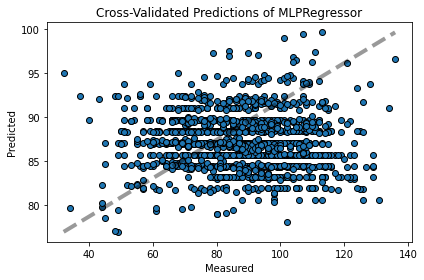

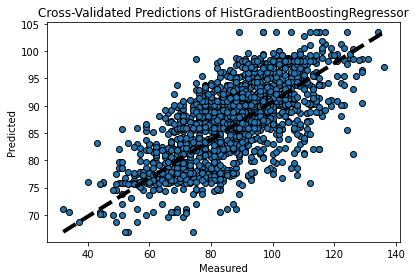

In [ ]:

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:

mlpr = MLPRegressor(hidden_layer_sizes=(50, 50),
                                     learning_rate_init=0.01,
                                     early_stopping=True)

hgbr=HistGradientBoostingRegressor(loss='least_squares', learning_rate=0.01)

predictedm = cross_val_predict(mlpr, X_n10_3_i_4, E_n10_3_i_4 , cv=3)
predictedh = cross_val_predict(hgbr, X_n10_3_i_4, E_n10_3_i_4 , cv=3)

fig1 = plt.figure()
plt.scatter(E_n10_3_i_4, predictedm, edgecolors=(0, 0, 0))
plt.plot([E_n10_3_i_4.min(), E_n10_3_i_4.max()], [predictedm.min(), predictedm.max()],
         'k--', lw=4, alpha=0.4)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title("Cross-Validated Predictions of MLPRegressor")
plt.tight_layout()
fig2 = plt.figure()
plt.scatter(E_n10_3_i_4, predictedh, edgecolors=(0, 0, 0))
plt.plot([E_n10_3_i_4.min(), E_n10_3_i_4.max()], [predictedh.min(), predictedh.max()], 'k--', lw=4)
plt.xlabel('Measured')
plt.ylabel('Predicted')

plt.title("Cross-Validated Predictions of HistGradientBoostingRegressor")
plt.tight_layout()

plt.show()



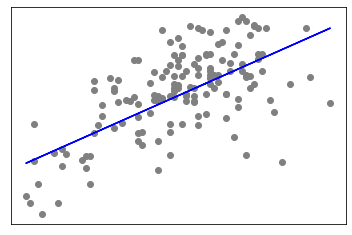

In [ ]:
E=np.reshape(np.float32(E_n10_3_i_4),(-1,1))
p=predictedh
X_tr, X_t, y_tr, y_t = train_test_split(E,p , test_size=0.1,random_state=0)
reg=LinearRegression()
reg.fit(X_tr,y_tr)
y_pr=reg.predict(X_t)
plt.scatter(X_t, y_t, c='grey')
plt.plot(X_t, y_pr, c="blue")
plt.xticks(())
plt.yticks(())

plt.show()

Automatically created module for IPython interactive environment
The Efficiency Loss Data is Normal Distribution !
Coefficients: 
 [-23.57992444   0.04123315  -1.48439328]
Mean squared error: 2.80
Coefficient of determination: 0.52


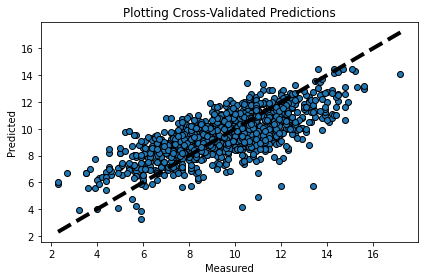

Training MLPRegressor...


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (900). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


done in 0.390s
Test R2 score: 0.64
Computing partial dependence plots...
done in 1.079s
Training GradientBoostingRegressor...
done in 0.482s
Test R2 score: 0.67
Computing partial dependence plots...
done in 0.348s


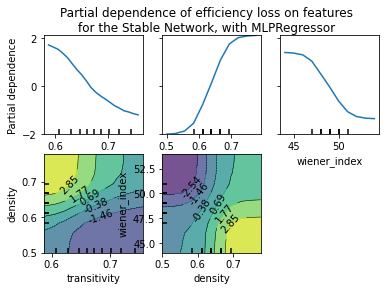

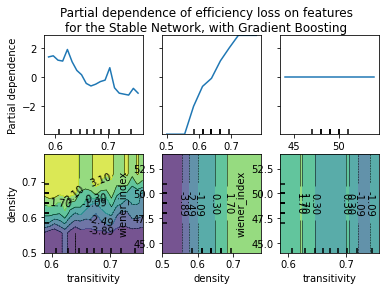

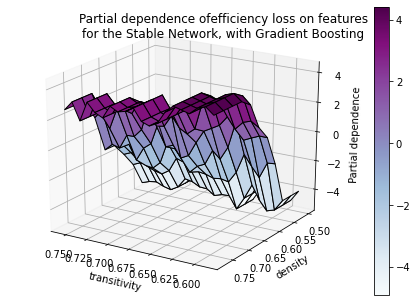

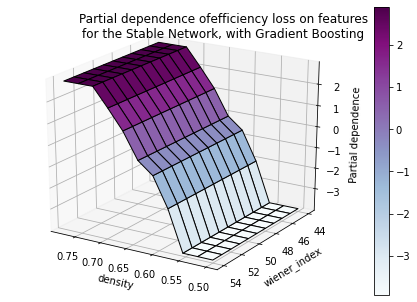

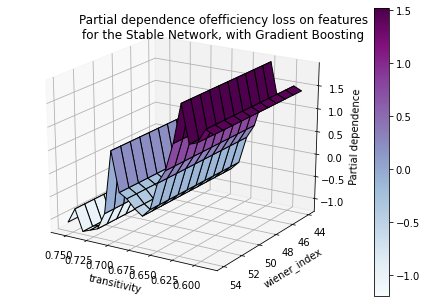

In [ ]:
with pd.ExcelFile('/content/drive/My Drive/output_values/output_n9_3.xlsx') as reader:
    
    closeness_n9_3=pd.read_excel(reader,sheet_name="closeness_centrality")
    betweenness_n9_3=pd.read_excel(reader,sheet_name="betweenness_centrality")
    eigenvector_n9_3=pd.read_excel(reader,sheet_name="eigenvector_centrality")
    page_rank_n9_3=pd.read_excel(reader,sheet_name="page_rank")
    triangles_n9_3=pd.read_excel(reader,sheet_name="triangles")
    clustering_n9_3=pd.read_excel(reader,sheet_name="clustering")
    wiener_index_n9_3=pd.read_excel(reader,sheet_name="wiener_index")
    transitivity_n9_3=pd.read_excel(reader,sheet_name="transitivity")
    eccentricity_n9_3=pd.read_excel(reader,sheet_name="eccentricity")

    diameter_radius_center_periphery_density_n9_3=pd.read_excel(reader,sheet_name="d_r_c_p_d")
    Efficiency_loss_n9_3=pd.read_excel(reader,sheet_name="Efficiency_loss")

X_n9_3,t_n9_3,d_n9_3,w_n9_3,E_n9_3,E_pred9=MLR_stable(transitivity_n9_3, diameter_radius_center_periphery_density_n9_3, 
                                      wiener_index_n9_3,Efficiency_loss_n9_3,part_rate=-300)
node9_cross_val=cross_val_stable(X_n9_3,E_n9_3)
#IsotonicReg_9=IsotonicReg_stable(diameter_radius_center_periphery_density_n9_3[4],Efficiency_loss_n9_3[0])
MLP_n19_3=MLPregression(transitivity_n9_3, diameter_radius_center_periphery_density_n9_3, wiener_index_n9_3,Efficiency_loss_n9_3)



Automatically created module for IPython interactive environment
The Efficiency Loss Data is Normal Distribution !
Coefficients: 
 [-1.38760953e+01 -2.12767168e+12 -7.59882743e+10]
Mean squared error: 1.50
Coefficient of determination: 0.49


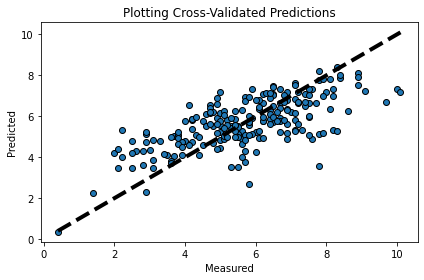

Training MLPRegressor...
done in 0.066s
Test R2 score: 0.12
Computing partial dependence plots...


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (196). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


done in 0.741s
Training GradientBoostingRegressor...
done in 0.133s
Test R2 score: 0.26
Computing partial dependence plots...
done in 0.366s


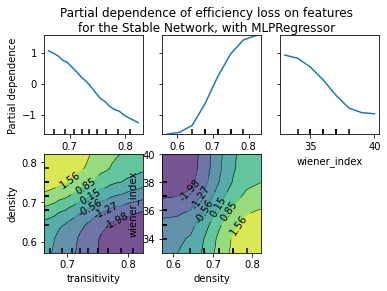

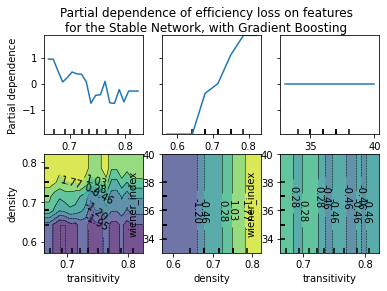

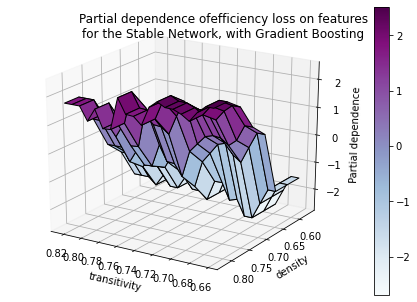

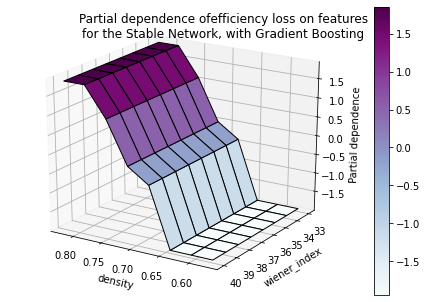

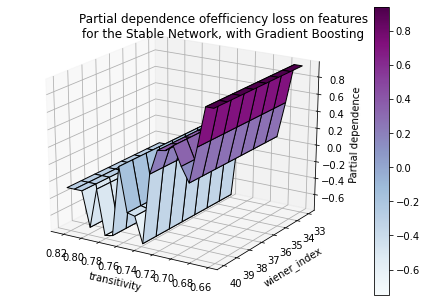

In [ ]:
with pd.ExcelFile('/content/drive/My Drive/output_values/output_n8_3.xlsx') as reader:
    
    closeness_n8_3=pd.read_excel(reader,sheet_name="closeness_centrality")
    betweenness_n8_3=pd.read_excel(reader,sheet_name="betweenness_centrality")
    eigenvector_n8_3=pd.read_excel(reader,sheet_name="eigenvector_centrality")
    page_rank_n8_3=pd.read_excel(reader,sheet_name="page_rank")
    triangles_n8_3=pd.read_excel(reader,sheet_name="triangles")
    clustering_n8_3=pd.read_excel(reader,sheet_name="clustering")
    wiener_index_n8_3=pd.read_excel(reader,sheet_name="wiener_index")
    transitivity_n8_3=pd.read_excel(reader,sheet_name="transitivity")
    eccentricity_n8_3=pd.read_excel(reader,sheet_name="eccentricity")

    diameter_radius_center_periphery_density_n8_3=pd.read_excel(reader,sheet_name="d_r_c_p_d")
    Efficiency_loss_n8_3=pd.read_excel(reader,sheet_name="Efficiency_loss")

X_n8_3,t_n8_3,d_n8_3,w_n8_3,E_n8_3,E_pred8=MLR_stable(transitivity_n8_3, diameter_radius_center_periphery_density_n8_3, 
                                      wiener_index_n8_3,Efficiency_loss_n8_3,part_rate=-300)
node8_cross_val=cross_val_stable(X_n8_3,E_n8_3)
#IsotonicReg_8=IsotonicReg_stable(diameter_radius_center_periphery_density_n8_3[4],Efficiency_loss_n8_3[0])
MLP_n8_3=MLPregression(transitivity_n8_3, diameter_radius_center_periphery_density_n8_3, wiener_index_n8_3,Efficiency_loss_n8_3)



Automatically created module for IPython interactive environment
The Efficiency Loss Data is Normal Distribution !
Coefficients: 
 [-1.28226887e+01  1.84231095e+13  8.77290930e+11]
Mean squared error: 1.45
Coefficient of determination: 0.61


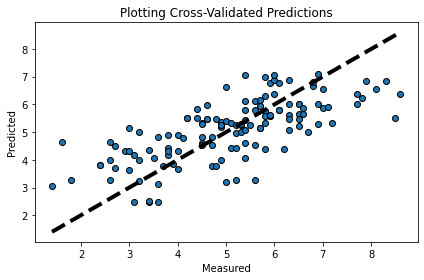

Training MLPRegressor...
done in 0.067s
Test R2 score: 0.46
Computing partial dependence plots...


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (121). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


done in 0.515s
Training GradientBoostingRegressor...
done in 0.066s
Test R2 score: 0.45
Computing partial dependence plots...
done in 0.366s


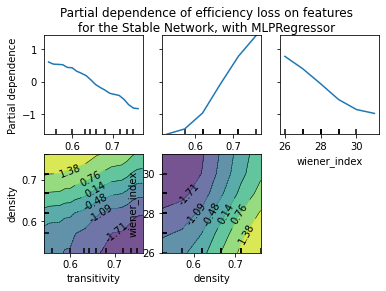

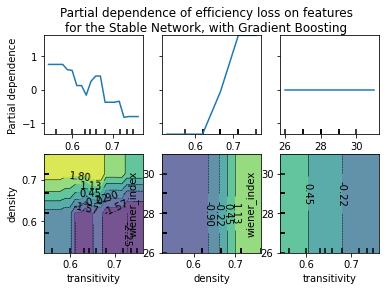

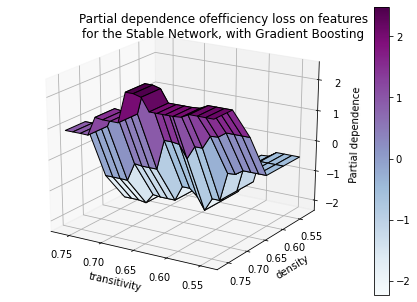

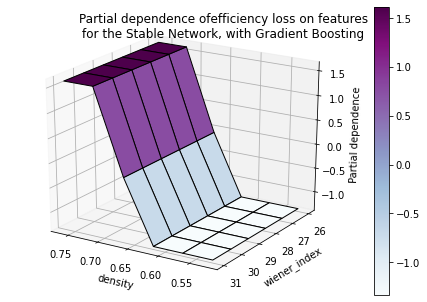

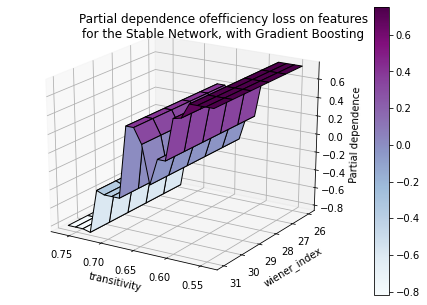

In [ ]:
with pd.ExcelFile('/content/drive/My Drive/output_values/output_n7_3.xlsx') as reader:
    
    closeness_n7_3=pd.read_excel(reader,sheet_name="closeness_centrality")
    betweenness_n7_3=pd.read_excel(reader,sheet_name="betweenness_centrality")
    eigenvector_n7_3=pd.read_excel(reader,sheet_name="eigenvector_centrality")
    page_rank_n7_3=pd.read_excel(reader,sheet_name="page_rank")
    triangles_n7_3=pd.read_excel(reader,sheet_name="triangles")
    clustering_n7_3=pd.read_excel(reader,sheet_name="clustering")
    wiener_index_n7_3=pd.read_excel(reader,sheet_name="wiener_index")
    transitivity_n7_3=pd.read_excel(reader,sheet_name="transitivity")
    eccentricity_n7_3=pd.read_excel(reader,sheet_name="eccentricity")

    diameter_radius_center_periphery_density_n7_3=pd.read_excel(reader,sheet_name="d_r_c_p_d")
    Efficiency_loss_n7_3=pd.read_excel(reader,sheet_name="Efficiency_loss")

X_n7_3,t_n7_3,d_n7_3,w_n7_3,E_n7_3,E_pred7=MLR_stable(transitivity_n7_3, diameter_radius_center_periphery_density_n7_3, 
                                      wiener_index_n7_3,Efficiency_loss_n7_3,part_rate=-20)
node7_cross_val=cross_val_stable(X_n7_3,E_n7_3)
#IsotonicReg_7=IsotonicReg_stable(diameter_radius_center_periphery_density_n7_3[4],Efficiency_loss_n7_3[0])

MLP_n7_3=MLPregression(transitivity_n7_3, diameter_radius_center_periphery_density_n7_3, wiener_index_n7_3,Efficiency_loss_n7_3)



Automatically created module for IPython interactive environment
The Efficiency Loss Data is Normal Distribution !
Coefficients: 
 [-4.85204039  0.06969322 -1.04539823]
Mean squared error: 1.21
Coefficient of determination: 0.38


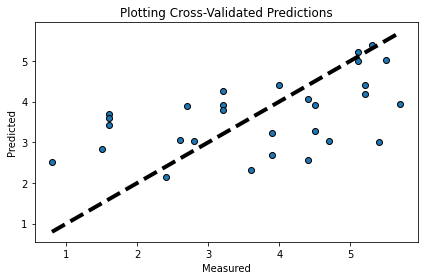

In [ ]:

with pd.ExcelFile('/content/drive/My Drive/output_values/output_n6_3.xlsx') as reader:
    
    closeness_n6_3=pd.read_excel(reader,sheet_name="closeness_centrality")
    betweenness_n6_3=pd.read_excel(reader,sheet_name="betweenness_centrality")
    eigenvector_n6_3=pd.read_excel(reader,sheet_name="eigenvector_centrality")
    page_rank_n6_3=pd.read_excel(reader,sheet_name="page_rank")
    triangles_n6_3=pd.read_excel(reader,sheet_name="triangles")
    clustering_n6_3=pd.read_excel(reader,sheet_name="clustering")
    wiener_index_n6_3=pd.read_excel(reader,sheet_name="wiener_index")
    transitivity_n6_3=pd.read_excel(reader,sheet_name="transitivity")
    eccentricity_n6_3=pd.read_excel(reader,sheet_name="eccentricity")

    diameter_radius_center_periphery_density_n6_3=pd.read_excel(reader,sheet_name="d_r_c_p_d")
    Efficiency_loss_n6_3=pd.read_excel(reader,sheet_name="Efficiency_loss")

X_n6_3,t_n6_3,d_n6_3,w_n6_3,E_n6_3,E_pred8=MLR_stable(transitivity_n6_3, diameter_radius_center_periphery_density_n6_3, 
                                      wiener_index_n6_3,Efficiency_loss_n6_3,part_rate=-300)
node6_cross_val=cross_val_stable(X_n6_3,E_n6_3)

